In [76]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [77]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
print(mnist)

{'DESCR': 'mldata.org dataset: mnist-original', 'COL_NAMES': ['label', 'data'], 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.]), 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}


In [78]:
X,y  = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


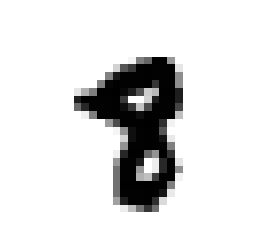

In [90]:
%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt 
some_digit = X[50006]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

Note that the training set is split where the first 60k images is the test set and the last 10k are test set.

In [81]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Attempt to crate a one vs all 5 binary classfier

In [82]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test ==5)

In [84]:
skfolds = StratifiedKFold(n_splits=3,random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct)

19335
19258
19314


In [85]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[-251947.83881399]


In [86]:
threshold = 0
y_some_digit_pred = (y_scores < threshold)
print(y_some_digit_pred)

[ True]


In [87]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
print(y_scores)

[[      0.          -66687.39020995]
 [      0.         -881608.31021452]
 [      0.         -969572.82745091]
 ..., 
 [      0.         -933124.87712053]
 [      0.         -180796.8058366 ]
 [      0.         -317796.98991712]]


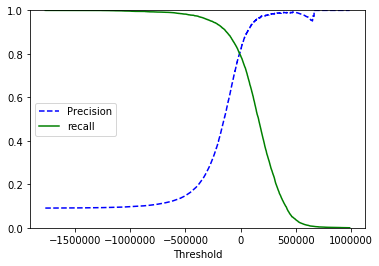

In [95]:
%matplotlib inline 
from sklearn.metrics import precision_recall_curve 
import matplotlib.pyplot as plt 


precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores[:,1])

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()